In [ ]:
import os

# Define directory names
dir_names = ["yes", "no", "augmented data/yes", "augmented data/no"]

# Create directories
for dir_name in dir_names:
    os.makedirs(dir_name, exist_ok=True)



Brain Tumor Detection Using a Convolutional Neural Network
About the Brain MRI Images dataset:
The dataset contains 2 folders: yes and no which contains 200 Brain MRI Images. The folder yes contains 200 Brain MRI Images that are tumorous and the folder no contains 200 Brain MRI Images that are non-tumorous.



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from os import listdir
import time

%matplotlib inline

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """

    from os import listdir

    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )


    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir+filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [ ]:
start_time = time.time()


# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir="/content/yes/", n_generated_samples=5, save_to_dir="/content/augmented data/yes")
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir="/content/no/", n_generated_samples=5, save_to_dir="/content/augmented data/no")

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:1:26.6


Let's see how many tumorous and non-tumorous examples after performing data augmentation:

In [ ]:
def data_summary(main_path):

    yes_path = main_path+'yes'
    no_path = main_path+'no'

    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)

    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [ ]:
data_summary("/content/augmented data/")

Number of examples: 2400
Percentage of positive examples: 50.0%, number of pos examples: 1200
Percentage of negative examples: 50.0%, number of neg examples: 1200


Data Preparation & Preprocessing In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.

In [ ]:
def crop_brain_contour(image, plot=False):
  # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

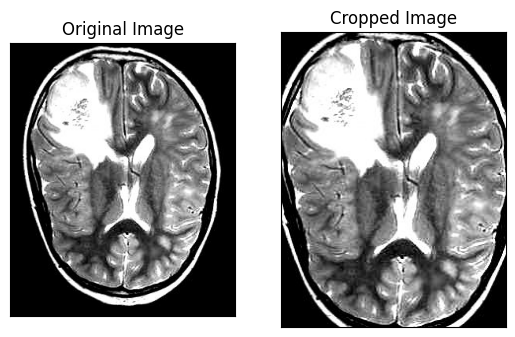

In [ ]:
#In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:
ex_img = cv2.imread('/content/yes/y0.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

Load up the data:
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

Read the image.
Crop the part of the image representing only the brain.
Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
Apply normalization because we want pixel values to be scaled to the range 0-1.
Append the image to X and its label to y.
After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.
Note: the augmented data directory contains not only the new generated images but also the original images.

In [ ]:
augmented_path = '/content/augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2400
X shape is: (2400, 240, 240, 3)
y shape is: (2400, 1)


As we see, we have 2399 images. Each images has a shape of (240, 240, 3)=(image_width, image_height, number_of_channels)

In [ ]:
print(X)

[[[[0.04313725 0.04313725 0.04313725]
   [0.04313725 0.04313725 0.04313725]
   [0.04313725 0.04313725 0.04313725]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]]

  [[0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]]

  [[0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]]

  ...

  [[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.02352941 0.02352941 0.02352941]
   [0.02745098 0.02745098 0.02745098]
   [0.02745098 0.02745098 0.02745098]]

  [[0.01960784 0.01960784 0.01960784]
   [0.0

In [ ]:
print(y)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


Plot sample images:

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

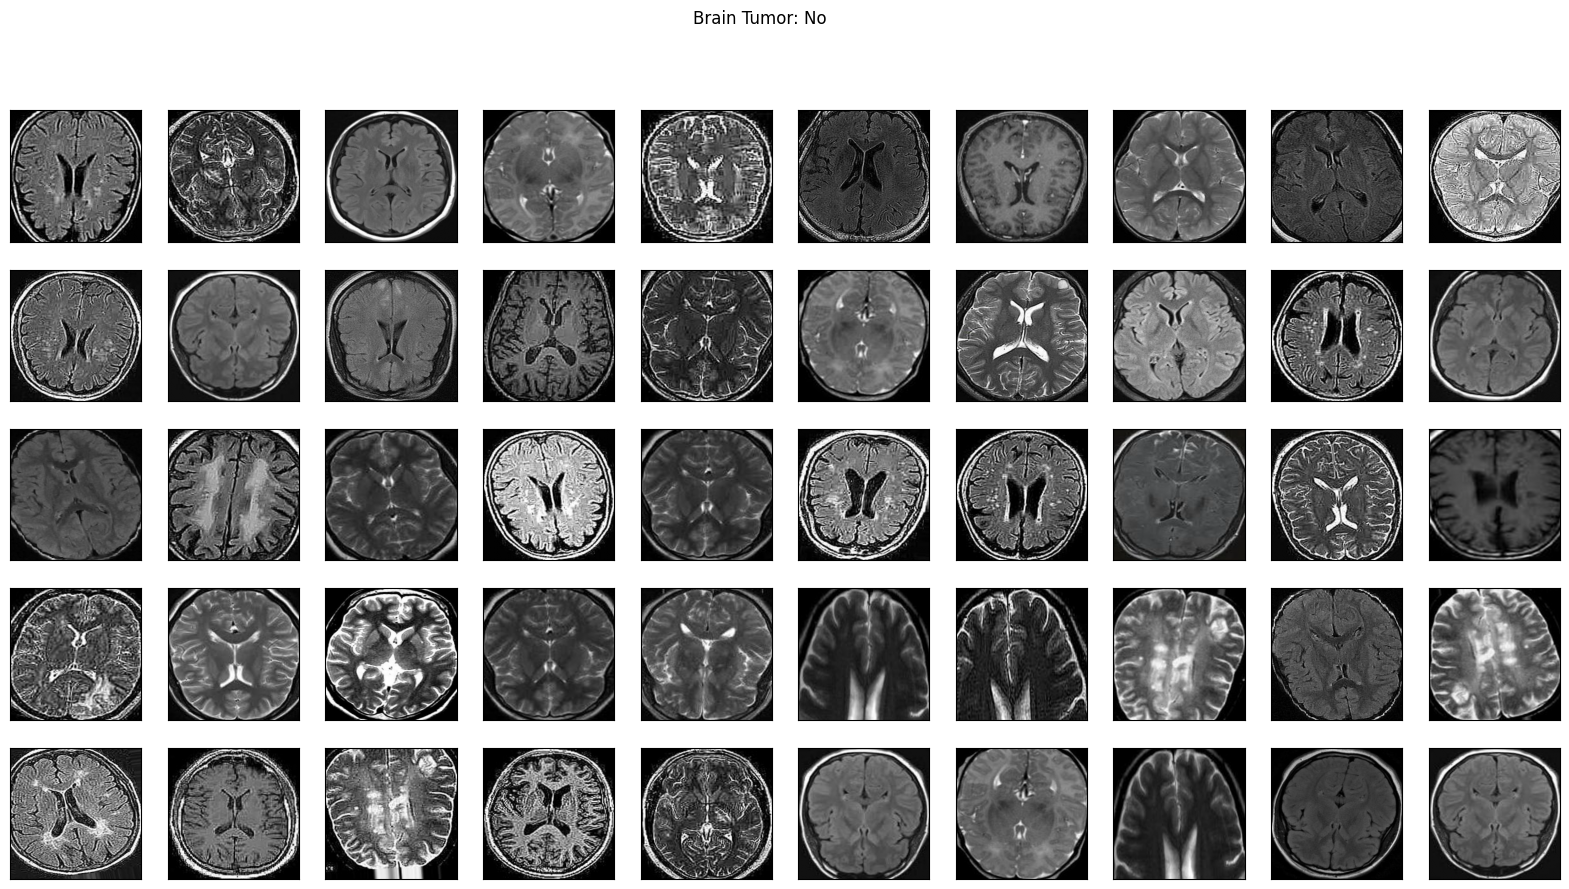

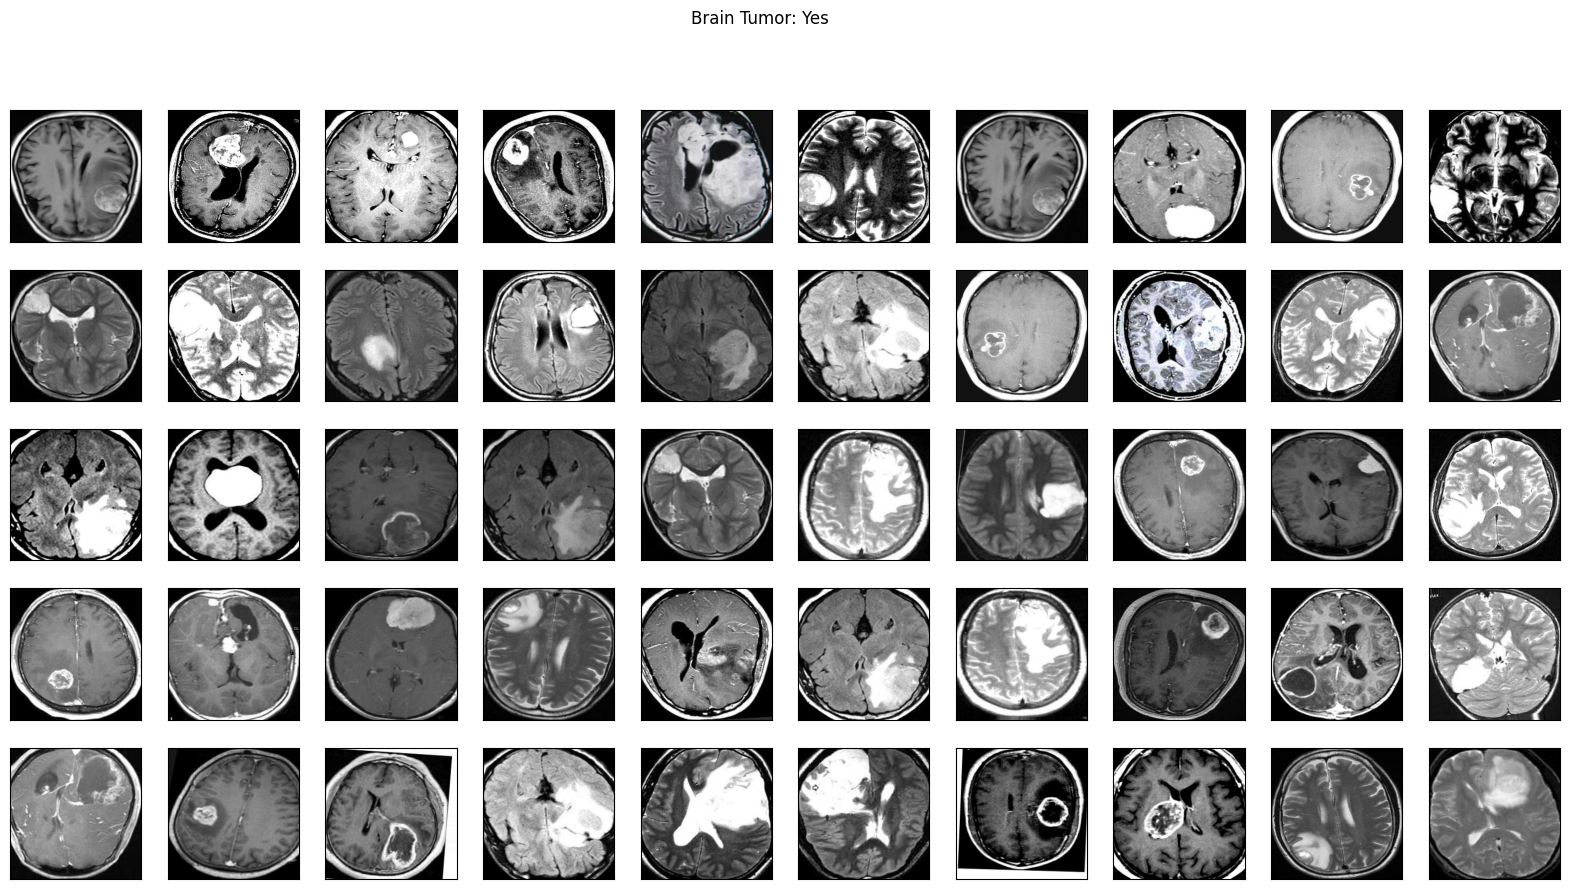

In [ ]:
plot_sample_images(X, y)

In [ ]:
import shutil

# Replace folder_path with the path of the folder you want to delete
folder_path = '/content/yes'
folder_path2 = '/content/no'
folder_path3 = '/content/augmented data'

# Use shutil.rmtree() to delete the folder and all its contents
shutil.rmtree(folder_path)
shutil.rmtree(folder_path2)
shutil.rmtree(folder_path3)

Split the data:
Split X and y into training, validation (development) and validation sets.

In [ ]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:

70% of the data for training.
15% of the data for validation.
15% of the data for testing.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
del X
del y

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1680
number of development examples = 360
number of test examples = 360
X_train shape: (1680, 240, 240, 3)
Y_train shape: (1680, 1)
X_val (dev) shape: (360, 240, 240, 3)
Y_val (dev) shape: (360, 1)
X_test shape: (360, 240, 240, 3)
Y_test shape: (360, 1)


In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

Build the model

Let's build a convolutional neural network model:

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2

def build_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Load the VGG16 model with pre-trained weights, excluding the top layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the VGG16 model so that they are not trained during transfer learning
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Extract features from the VGG16 model
    X = vgg16_base(X_input)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # First convolutional layer
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # First max pooling layer
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # Second convolutional layer
    X = Conv2D(64, (3,3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 55, 55, 64)

    # Second max pooling layer
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 13, 13, 64)

    # First Average pooling layer
    X = AveragePooling2D((2, 2), name='Avg_pool0')(X) # shape=(?, 6, 6, 64)

    # Third convolutional layer
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 4, 4, 128)

    # Second Average pooling layer
    X = AveragePooling2D((2, 2), name='Avg_pool1')(X) # shape=(?, 2, 2, 128)

    # Fourth convolutional layer
    X = Conv2D(128, (1,1), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 2, 2, 256)

    # Fourth max pooling layer
    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 512)

    # DROPOUT
    X = Dropout(0.3)(X)

    # FULLYCONNECTED
    X = Dense(1,activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Define the optimizer with a learning rate of 0.001.
    optimizer = RMSprop(lr=0.001)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model


Define the image shape:

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)


In [ ]:
model = build_model(IMG_SHAPE)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()


Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [ ]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy]
filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.model"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

Train the model

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
53/53 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.7982

53/53 [==============================] - 20s 139ms/step - loss: 0.4495 - accuracy: 0.7982 - val_loss: 0.3700 - val_accuracy: 0.8111
Epoch 2/25
52/53 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.8708

53/53 [==============================] - 6s 106ms/step - loss: 0.2856 - accuracy: 0.8714 - val_loss: 0.3703 - val_accuracy: 0.8389
Epoch 3/25
52/53 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9026

53/53 [==============================] - 6s 112ms/step - loss: 0.2267 - accuracy: 0.9030 - val_loss: 1.5557 - val_accuracy: 0.6000
Epoch 4/25
52/53 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9285

53/53 [==============================] - 6s 105ms/step - loss: 0.1762 - accuracy: 0.9286 - val_loss: 0.2915 - val_accuracy: 0.8889
Epoch 5/25
52/53 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9393

53/53 [==============================] - 6s 107ms/step - loss: 0.1581 - accuracy: 0.9399 - val_loss: 0.7394 - val_accuracy: 0.7694
Epoch 6/25
52/53 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9429

53/53 [==============================] - 7s 124ms/step - loss: 0.1483 - accuracy: 0.9429 - val_loss: 0.3043 - val_accuracy: 0.8778
Epoch 7/25
52/53 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9471

53/53 [==============================] - 6s 108ms/step - loss: 0.1313 - accuracy: 0.9476 - val_loss: 0.1406 - val_accuracy: 0.9389
Epoch 8/25
52/53 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9567

53/53 [==============================] - 6s 111ms/step - loss: 0.1172 - accuracy: 0.9554 - val_loss: 0.5240 - val_accuracy: 0.8472
Epoch 9/25
52/53 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9688

53/53 [==============================] - 6s 111ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.1828 - val_accuracy: 0.9417
Epoch 10/25
52/53 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9718

53/53 [==============================] - 5s 104ms/step - loss: 0.0675 - accuracy: 0.9714 - val_loss: 0.7102 - val_accuracy: 0.8083
Epoch 11/25
52/53 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9766

53/53 [==============================] - 6s 124ms/step - loss: 0.0689 - accuracy: 0.9762 - val_loss: 0.1671 - val_accuracy: 0.9389
Epoch 12/25
52/53 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9736

53/53 [==============================] - 6s 104ms/step - loss: 0.0685 - accuracy: 0.9738 - val_loss: 0.1405 - val_accuracy: 0.9333
Epoch 13/25
52/53 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9700

53/53 [==============================] - 6s 118ms/step - loss: 0.0776 - accuracy: 0.9702 - val_loss: 0.2437 - val_accuracy: 0.9083
Epoch 14/25
52/53 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9802

53/53 [==============================] - 5s 104ms/step - loss: 0.0518 - accuracy: 0.9804 - val_loss: 0.1003 - val_accuracy: 0.9639
Epoch 15/25
52/53 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9886

53/53 [==============================] - 6s 121ms/step - loss: 0.0439 - accuracy: 0.9887 - val_loss: 0.0851 - val_accuracy: 0.9694
Epoch 16/25
52/53 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9808

53/53 [==============================] - 5s 103ms/step - loss: 0.0622 - accuracy: 0.9810 - val_loss: 0.1298 - val_accuracy: 0.9583
Epoch 17/25
52/53 [============================>.] - ETA: 0s - loss: 0.0429 - accuracy: 0.9850

53/53 [==============================] - 6s 118ms/step - loss: 0.0440 - accuracy: 0.9845 - val_loss: 0.1583 - val_accuracy: 0.9639
Epoch 18/25
52/53 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9868

53/53 [==============================] - 6s 110ms/step - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.0676 - val_accuracy: 0.9833
Epoch 19/25
52/53 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9838

53/53 [==============================] - 6s 119ms/step - loss: 0.0458 - accuracy: 0.9839 - val_loss: 0.3447 - val_accuracy: 0.8861
Epoch 20/25
52/53 [============================>.] - ETA: 0s - loss: 0.0332 - accuracy: 0.9904

53/53 [==============================] - 6s 111ms/step - loss: 0.0334 - accuracy: 0.9905 - val_loss: 0.6258 - val_accuracy: 0.8056
Epoch 21/25
52/53 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9898

53/53 [==============================] - 6s 120ms/step - loss: 0.0364 - accuracy: 0.9899 - val_loss: 0.0564 - val_accuracy: 0.9806
Epoch 22/25
52/53 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9934

53/53 [==============================] - 6s 114ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.3404 - val_accuracy: 0.9000
Epoch 23/25
52/53 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9898

53/53 [==============================] - 6s 119ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.0815 - val_accuracy: 0.9667
Epoch 24/25
52/53 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9970

53/53 [==============================] - 6s 106ms/step - loss: 0.0144 - accuracy: 0.9970 - val_loss: 0.0413 - val_accuracy: 0.9861
Epoch 25/25
52/53 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9940

53/53 [==============================] - 7s 126ms/step - loss: 0.0254 - accuracy: 0.9940 - val_loss: 0.1194 - val_accuracy: 0.9583
Elapsed time: 0:3:25.6


In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


Plot Loss & Accuracy


In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

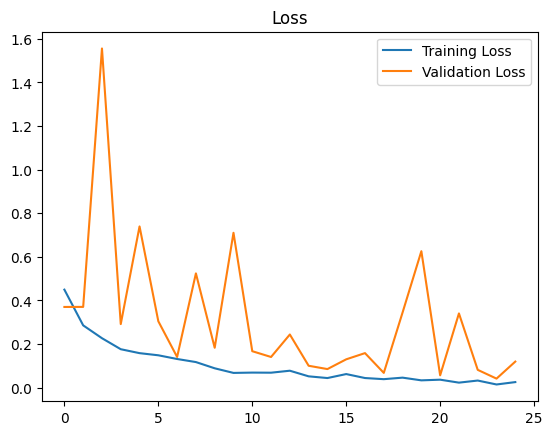

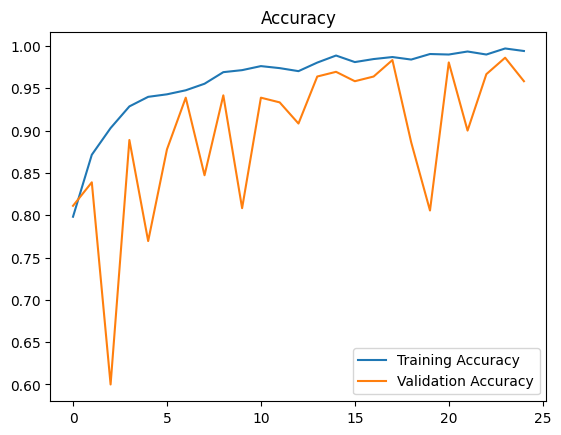

In [ ]:
plot_metrics(history)

Results

Let's experiment with the best model (the one with the best validation accuracy):

Load the best model

In [ ]:
best_model = load_model(filepath='/content/models/models/cnn-parameters-improvement-24-0.99.model.model')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

12/12 [==============================] - 1s 27ms/step - loss: 0.0296 - accuracy: 0.9917


Accuracy of the best model on the testing data:

In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.02964913658797741
Test Accuracy = 0.9916666746139526


F1 score for the best model on the testing data:

In [ ]:
y_test_prob = best_model.predict(X_test)

12/12 [==============================] - 0s 24ms/step


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9915014164305949


Let's also find the f1 score on the validation data:

In [ ]:
y_val_prob = best_model.predict(X_val)

12/12 [==============================] - 0s 26ms/step


In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.986737400530504


Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1680
Percentage of positive examples: 49.76190476190476%, number of pos examples: 836
Percentage of negative examples: 50.23809523809524%, number of neg examples: 844
Validation Data:
Number of examples: 360
Percentage of positive examples: 52.22222222222222%, number of pos examples: 188
Percentage of negative examples: 47.77777777777778%, number of neg examples: 172
Testing Data:
Number of examples: 360
Percentage of positive examples: 48.888888888888886%, number of pos examples: 176
Percentage of negative examples: 51.111111111111114%, number of neg examples: 184


As expectred, the percentage of positive examples are around 50%.

Conclusion:
Now, the model detects brain tumor with:
90% accuracy on the test set.
0.93 f1 score on the test set.
These resutls are very good considering that the data is balanced.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate model performance on test set
y_test_pred = (y_test_prob > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_acc = (tp + tn) / (tn + fp + fn + tp)
test_precision = tp / (tp + fp)
test_recall = tp / (tp + fn)
test_f1 = 2 * ((test_precision * test_recall) / (test_precision + test_recall))

# Evaluate model performance on validation set
y_val_pred = (y_val_prob > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
val_acc = (tp + tn) / (tn + fp + fn + tp)
val_precision = tp / (tp + fp)
val_recall = tp / (tp + fn)
val_f1 = 2 * ((val_precision * val_recall) / (val_precision + val_recall))

# Print performance table
print("Model performance:")
print("Test set:")
print(f"Accuracy: {test_acc:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 score: {test_f1:.2f}")
print(classification_report(y_test, y_test_pred))

print("Validation set:")
print(f"Accuracy: {val_acc:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1 score: {val_f1:.2f}")
print(classification_report(y_val, y_val_pred))


Model performance:
Test set:
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 score: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       184
           1       0.99      0.99      0.99       176

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

Validation set:
Accuracy: 0.99
Precision: 0.98
Recall: 0.99
F1 score: 0.99
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       172
           1       0.98      0.99      0.99       188

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



Testing model's performance on a random image downloaded from google, remember to convert best model into tflite file format and insert it's path in the model_path

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
model_path = '/content/CNNBrainTumorModelVGG16.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
img_path = '/content/brain-tumor-ini-ft3.jpg'   # download any image from google and insert it's path
img = cv2.imread(img_path)
img = crop_brain_contour(img, plot=False)
img = cv2.resize(img, (240, 240))
img = img.astype('float32') / 255.0

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
pred_prob = output_data[0][0]

# Classify the image based on the prediction probability
if pred_prob > 0.5:
    print('Tumor present with probability {:.2f}%'.format(pred_prob * 100))
else:
    print('Tumor not present with probability {:.2f}%'.format((1 - pred_prob) * 100))


Tumor present with probability 99.00%


Convert best model into tflite file format and download

In [ ]:
tf.keras.models.save_model(best_model,'model.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model = best_model)
model_tflite = converter.convert()
open("CNNBrainTumorModelVGG16.tflite","wb").write(model_tflite)


460856